# Instalação de bibliotecas necessárias

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn_extra.cluster import KMedoids

# Download do dataset rohan0301/unsupervised-learning-on-country-data

In [21]:
def download_dataset_to_custom_dir(dataset_handle: str, target_parent_dir: str):
    # Baixa o dataset (isso cria uma subpasta com número da versão, ex: .../2/)
    downloaded_path = kagglehub.dataset_download(dataset_handle)

    # Extrai o nome do dataset (última parte do handle)
    dataset_name = dataset_handle.split("/")[-1]

    # Caminho final desejado: ../datasets/unsupervised-learning-on-country-data/
    target_dir = os.path.join(target_parent_dir, dataset_name)

    # Garante que a pasta ../datasets/ existe
    os.makedirs(target_parent_dir, exist_ok=True)

    # Remove destino se já existir
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    # Move a pasta baixada para o destino desejado
    shutil.move(downloaded_path, target_dir)

    print(f"✅ Dataset baixado para: {target_dir}")
    return target_dir

# ===== Download do dataset =====
dataset_path = download_dataset_to_custom_dir(
    "rohan0301/unsupervised-learning-on-country-data",
    "../datasets"
)

100%|██████████| 5.21k/5.21k [00:00<00:00, 9.33MB/s]

Extracting model files...
✅ Dataset baixado para: ../datasets\unsupervised-learning-on-country-data


In [22]:
# Carregar o arquivo CSV do dataset baixado
# ===== Leitura do CSV com pandas =====
csv_path = os.path.join(dataset_path, "Country-data.csv")
df = pd.read_csv(csv_path)

# Verificar número de países

In [23]:
print("Número de países no dataset:", df['country'].nunique())

Número de países no dataset: 167


# Faixa dinâmica das variáveis

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

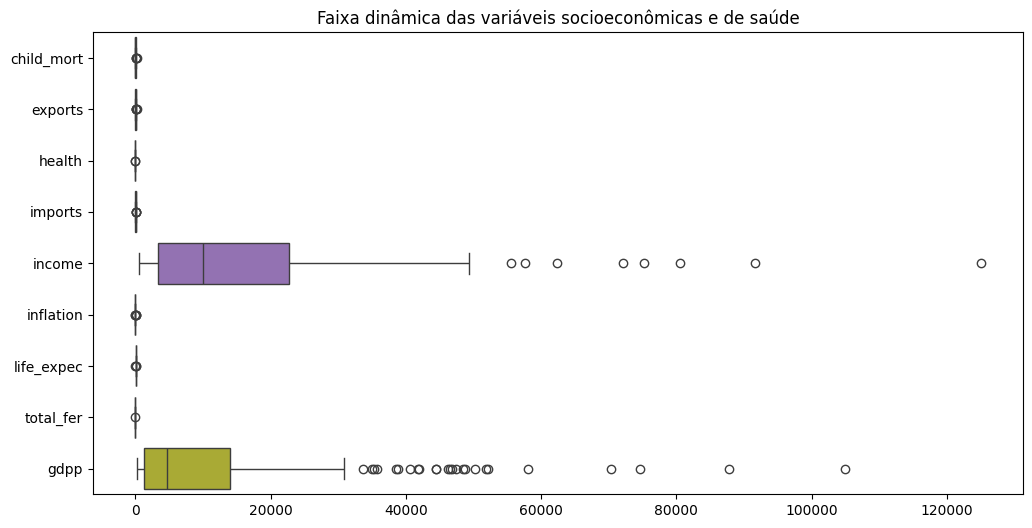

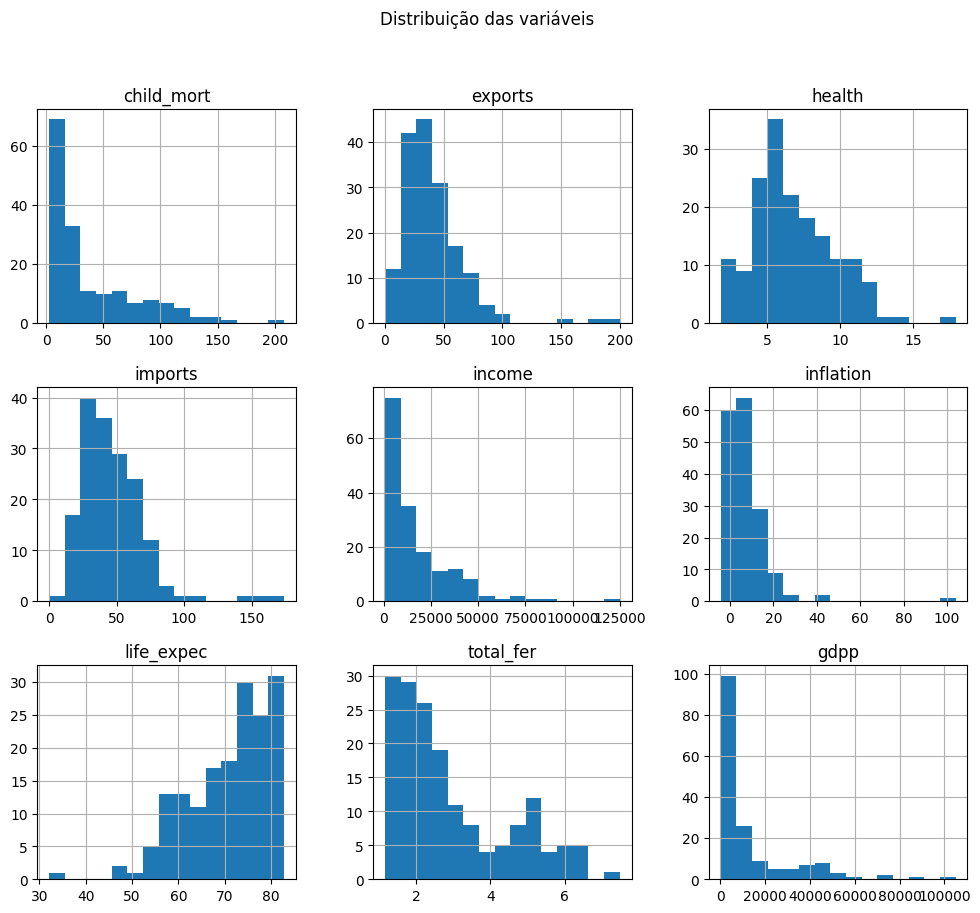

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remover a coluna de país (não numérica)
data_num = df.drop(columns=['country'])

# Estatísticas básicas
print(data_num.describe())

# Boxplots para ver faixas dinâmicas (escala e outliers)
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_num, orient='h')
plt.title("Faixa dinâmica das variáveis socioeconômicas e de saúde")
plt.show()

# Distribuição individual (opcional)
data_num.hist(figsize=(12, 10), bins=15)
plt.suptitle("Distribuição das variáveis")
plt.show()

# Pré-processamento

In [25]:
from sklearn.preprocessing import StandardScaler

# Remover coluna 'country'
X = df.drop(columns=['country'])

# Escalonamento (padronização)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converter de volta para DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(X_scaled.head())

   child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   -1.619092   
1   -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347    0.647866   
2   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274    0.670423   
3    2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   -1.179234   
4   -0.695634  0.160668 -0.286894  0.497568  0.101732  -0.601749    0.704258   

   total_fer      gdpp  
0   1.902882 -0.679180  
1  -0.859973 -0.485623  
2  -0.038404 -0.465376  
3   2.128151 -0.516268  
4  -0.541946 -0.041817  


# Aplicar o K-Means

In [26]:

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# Verificar distribuição
print(df['cluster_kmeans'].value_counts())

cluster_kmeans
0    86
2    45
1    36
Name: count, dtype: int64


## Interpretação dos clusters

In [27]:
centroids_kmeans = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=X.columns
)
centroids_kmeans['cluster'] = range(1, 4)
centroids_kmeans.round(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,22.46,40.27,6.25,47.36,12321.74,7.72,72.57,2.34,6461.77,1
1,5.00,58.74,8.81,51.49,45672.22,2.67,80.13,1.75,42494.44,2
2,95.11,28.60,6.30,42.31,3539.84,11.99,59.06,5.07,1766.71,3


In [28]:
cluster_summary = df.groupby('cluster_kmeans').mean(numeric_only=True)
display(cluster_summary)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_kmeans,,,,,,,,,
0,22.456977,40.273128,6.251047,47.362394,12321.744186,7.720884,72.566279,2.340349,6461.767442
1,5.000000,58.738889,8.807778,51.491667,45672.222222,2.671250,80.127778,1.752778,42494.444444
2,95.106667,28.602444,6.301111,42.306667,3539.844444,11.986778,59.055556,5.065333,1766.711111


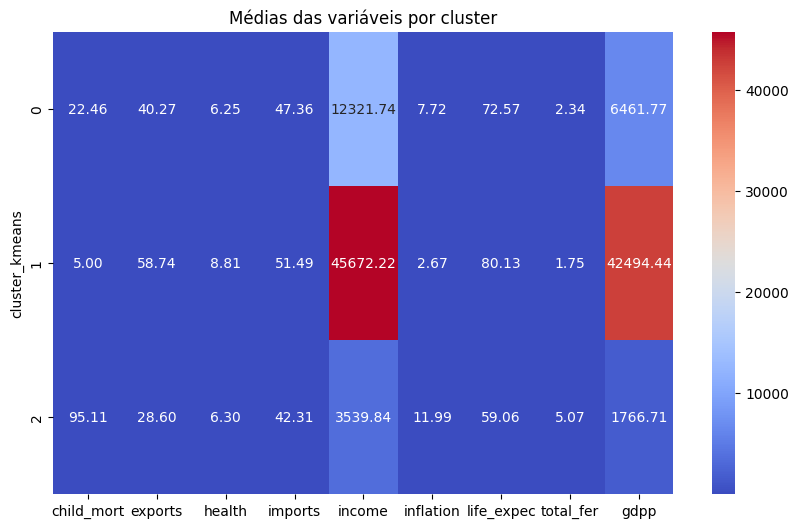

In [29]:
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Médias das variáveis por cluster')
plt.show()

## País que melhor representa cada cluster

In [30]:
# Função para calcular distâncias até os centróides
distances = kmeans.transform(X_scaled)

# País mais representativo por cluster
representative_countries = []
for i in range(3):
    cluster_indices = df[df['cluster_kmeans'] == i].index
    closest_index = cluster_indices[np.argmin(distances[cluster_indices, i])]
    representative_countries.append(df.loc[closest_index, 'country'])

print("País mais representativo de cada cluster:")
for i, country in enumerate(representative_countries):
    print(f"Cluster {i}: {country}")

País mais representativo de cada cluster:
Cluster 0: Suriname
Cluster 1: Iceland
Cluster 2: Guinea


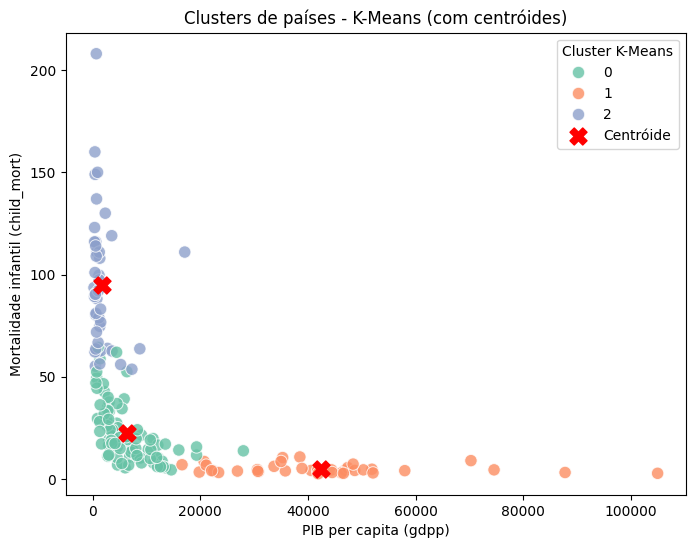

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x='gdpp', y='child_mort',
    hue='cluster_kmeans', palette='Set2', s=80, alpha=0.8
)

# Adicionar centróides
plt.scatter(
    centroids_kmeans['gdpp'],
    centroids_kmeans['child_mort'],
    s=150, c='red', marker='X', label='Centróide'
)


plt.title('Clusters de países - K-Means (com centróides)')
plt.xlabel('PIB per capita (gdpp)')
plt.ylabel('Mortalidade infantil (child_mort)')
plt.legend(title='Cluster K-Means')
plt.show()

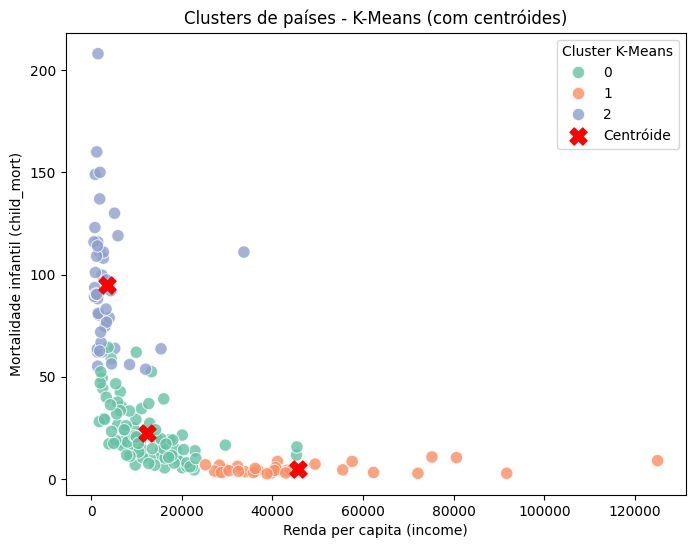

In [32]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x='income', y='child_mort',
    hue='cluster_kmeans', palette='Set2', s=80, alpha=0.8
)

# Adicionar centróides
plt.scatter(
    centroids_kmeans['income'],
    centroids_kmeans['child_mort'],
    s=150, c='red', marker='X', label='Centróide'
)


plt.title('Clusters de países - K-Means (com centróides)')
plt.xlabel('Renda per capita (income)')
plt.ylabel('Mortalidade infantil (child_mort)')
plt.legend(title='Cluster K-Means')
plt.show()

# Aplicar Clusterização Hierárquica 

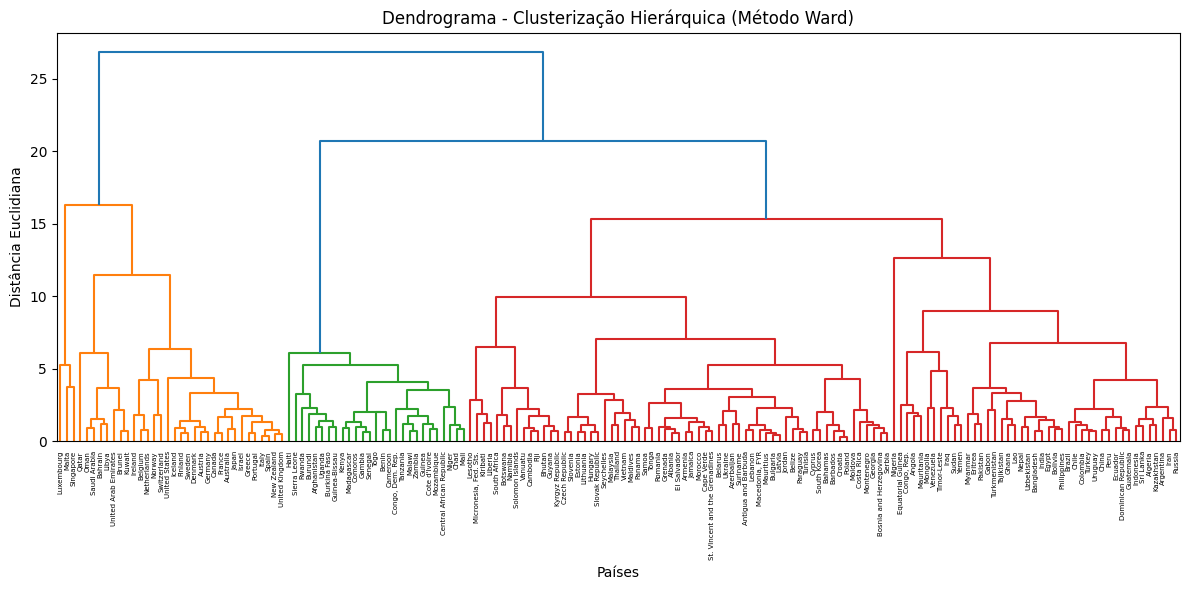

In [33]:
Z = linkage(X_scaled, method='ward')

# Plotar dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df['country'].values, leaf_rotation=90)
plt.title('Dendrograma - Clusterização Hierárquica (Método Ward)')
plt.xlabel('Países')
plt.ylabel('Distância Euclidiana')
plt.tight_layout()
plt.show()

In [34]:
# Extrair 3 clusters do dendrograma
df['cluster_hier'] = fcluster(Z, t=3, criterion='maxclust')

# Visualizar distribuição
print(df['cluster_hier'].value_counts())

cluster_hier
3    106
1     34
2     27
Name: count, dtype: int64


# Comparação K-Means x Classificação hierárquica

In [35]:
comparison = pd.crosstab(df['cluster_kmeans'], df['cluster_hier'])
print("Comparação entre K-Means e Hierárquico:")
print(comparison)

Comparação entre K-Means e Hierárquico:
cluster_hier     1   2   3
cluster_kmeans            
0                3   0  83
1               31   0   5
2                0  27  18


# Aplicar K-Medoids

In [36]:
# Aplicar K-Medoids com 3 clusters
kmedoids = KMedoids(n_clusters=3, random_state=42)
df['cluster_kmedoids'] = kmedoids.fit_predict(X_scaled)

# Ver os medóides (índices dos pontos reais escolhidos)
print("Índices dos medóides:", kmedoids.medoid_indices_)

# Mostrar os países medóides (representantes reais)
print("\nPaíses representativos (medóides):")
for i, idx in enumerate(kmedoids.medoid_indices_):
    print(f"Cluster {i}: {df.loc[idx, 'country']}")

Índices dos medóides: [  4 147  45]

Países representativos (medóides):
Cluster 0: Antigua and Barbuda
Cluster 1: Tanzania
Cluster 2: Dominican Republic


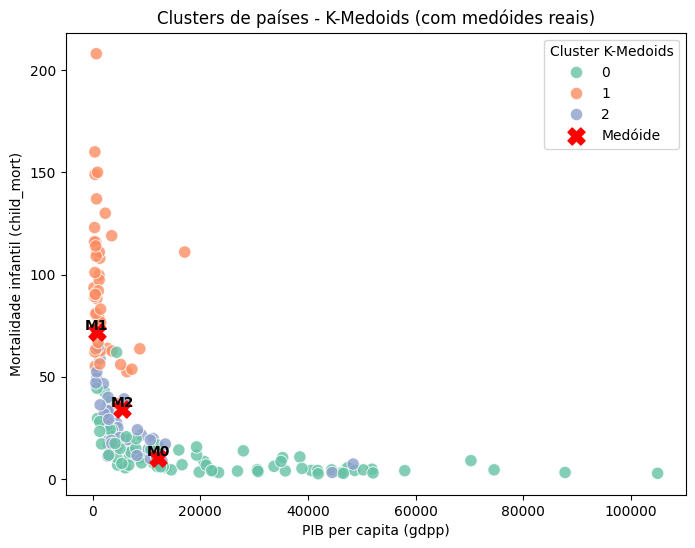

In [37]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x='gdpp', y='child_mort',
    hue='cluster_kmedoids', palette='Set2', s=80, alpha=0.8
)

# Adicionar os medóides (pontos reais)
plt.scatter(
    df.loc[kmedoids.medoid_indices_, 'gdpp'],
    df.loc[kmedoids.medoid_indices_, 'child_mort'],
    s=150, c='red', marker='X', label='Medóide'
)

# Rótulos dos medóides

for i, idx in enumerate(kmedoids.medoid_indices_):
    plt.text(
        df.loc[idx, 'gdpp'],
        df.loc[idx, 'child_mort'] + 1,
        f"M{i}", color='black', ha='center', fontweight='bold'
    )

plt.title('Clusters de países - K-Medoids (com medóides reais)')
plt.xlabel('PIB per capita (gdpp)')
plt.ylabel('Mortalidade infantil (child_mort)')
plt.legend(title='Cluster K-Medoids')
plt.show()


In [39]:
# Estatísticas médias de cada cluster
cluster_summary = df.groupby('cluster_kmedoids').mean(numeric_only=True)
display(cluster_summary.round(2))

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,cluster_hier
cluster_kmedoids,,,,,,,,,,,
0,11.74,57.03,7.37,57.67,28786.27,3.92,76.39,1.96,23454.75,0.45,2.15
1,92.96,29.15,6.39,42.32,3942.40,12.02,59.19,5.01,1922.38,1.91,2.43
2,25.37,27.06,6.34,33.69,11531.11,9.80,72.70,2.44,7012.36,0.04,2.91
